In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import datetime
import pandas as pd
import urllib2, urllib
import pytides
import os
import subprocess
import copy
from netCDF4 import Dataset
import pickle
from point_history import getmes
from int4 import bl4

In [3]:
path='/home/critechuser/tide/20160901.00/'

In [4]:
path='/mnt/rmdisk/tide/20131101.00/'

In [5]:
#start date
t1='20131101.00'

In [6]:
sdate=datetime.datetime.strptime(t1,'%Y%m%d.%H')

In [7]:
start=datetime.datetime.strftime(sdate,'%Y-%m-%d')

In [8]:
#end day
t2='20131210.00'

In [9]:
edate=datetime.datetime.strptime(t2,'%Y%m%d.%H')

In [10]:
end=datetime.datetime.strftime(edate,'%Y-%m-%d')

In [11]:
point=1858

## Observations

In [12]:
t,s,plat,plon,bname,bid = getmes(sdate,edate,point) # measured data

In [13]:
dic0={'time':t, 'Observation':[a for [a,b,c] in s], 'jrc_tide':[b for [a,b,c] in s], 'jrc_ss':[c for [a,b,c] in s]}
dat1=pd.DataFrame(dic0)
dat1=dat1.set_index('time')

In [14]:
dat1['Observation']=pd.to_numeric(dat1['Observation']) # convert string to floats
dat1['jrc_ss']=pd.to_numeric(dat1['jrc_ss']) # convert string to floats
dat1['jrc_tide']=pd.to_numeric(dat1['jrc_tide']) # convert string to floats

In [15]:
dat1.head()

,Observation,jrc_ss,jrc_tide
time,,,
2013-11-01 00:05:00,0.000,-0.045,0.045
2013-11-01 00:23:00,0.007,-0.038,0.045
2013-11-01 00:41:00,0.007,-0.039,0.046
2013-11-01 00:59:00,0.000,-0.050,0.050
2013-11-01 01:09:00,0.018,-0.035,0.053


In [16]:
demeaned=dat1['Observation'].values-dat1['Observation'].values.mean()

In [17]:
tide=pytides.tide.Tide.decompose(demeaned, dat1['Observation'].index)

In [18]:
constituent = [c.name for c in tide.model['constituent']]

In [19]:
df=pd.DataFrame(tide.model, index=constituent).drop('constituent', axis=1)

In [20]:
df.sort_values(by='amplitude', ascending=False).head(10) # 10 highest amplitudes

,amplitude,phase
S2,10.087247,181.117448
R2,8.686622,139.122908
T2,4.020833,42.879272
K2,3.249430,314.946648
S1,0.229919,327.918656
Mf,0.188023,231.967046
L2,0.173977,98.803768
lambda2,0.151345,6.473839
K1,0.119374,291.390517
MSF,0.118771,270.101960


## DELFT3D run

In [21]:
with open(path+'med.pkl', 'r') as f:
    ptr=pickle.load(f)

In [22]:
obsp=pd.read_csv(path+'med.obs',delim_whitespace=True,names=['idx','i','j'],header=None, engine='python')

In [23]:
#obsp=obsp.set_index('idx')

In [24]:
obsp.head()

,idx,i,j
0,819,116,193
1,833,6,107
2,834,206,160
3,884,4,116
4,899,204,226


In [25]:
# READ delft3d OUTPUT
dat=Dataset(path+'trih-med.nc') # with tidal force

In [26]:
h=dat['ZWL'][:,ptr[point]]

In [27]:
tt=dat['time'][:]

In [28]:
tstamp=[]
for t in tt:
    tstamp.append(sdate+datetime.timedelta(seconds=int(t)))

#### get xz,yz from map output

In [29]:
# READ delft3d OUTPUT
datm=Dataset(path+'trim-med.nc') # to get xz,yz

In [30]:
iv,ii,jj=obsp.xs(ptr[point]).values

In [31]:
xz=datm['XZ'][ii,jj]
yz=datm['YZ'][ii,jj]


In [32]:
print xz,yz
print plon,plat

13.4238 38.2332
13.371 38.121


In [33]:
# READ delft3d OUTPUT
fdat=Dataset(path+'NF/trih-med.nc') # WITHOUT tidal force

In [34]:
fh=fdat['ZWL'][:,ptr[point]]

In [35]:
dic1={'time':tstamp, 'hd':h, 'fh':fh}
dat2=pd.DataFrame(dic1)
dat2=dat2.set_index('time')

In [36]:
dat2['hd']=pd.to_numeric(dat2['hd']) # convert string to floats

In [37]:
dat2['fh']=pd.to_numeric(dat2['fh']) # convert string to floats

In [38]:
dat2['scaled'] = dat2['fh'] + dat1['Observation'].values.mean()

In [39]:
dat2.head()

,fh,hd,scaled
time,,,
2013-11-01 00:00:00,0.000000e+00,0.000000,0.159208
2013-11-01 00:10:00,-1.759803e-15,0.002657,0.159208
2013-11-01 00:20:00,-4.183826e-14,0.001584,0.159208
2013-11-01 00:30:00,1.223556e-14,-0.002698,0.159208
2013-11-01 00:40:00,-1.429785e-14,-0.010757,0.159208


## EXPECTED TIDE

In [40]:
tideset='../TIDES/med.nc'

In [41]:
tidal_c,amp,ph=bl4(tideset,xz,yz)

In [42]:
if amp.max()==0. :
    print 'using plon,plat'
    tidal_c,amp,ph=bl4(tideset,float(plon),float(plat))

In [43]:
#tidal_c,amp,ph=bl4(tideset,float(plon),float(plat))

In [44]:
dic3={'name':tidal_c,'amplitude':amp,'phase':ph}
df=pd.DataFrame(dic3)
df=df.set_index('name')
df

,amplitude,phase
name,,
M2,0.113913,235.933948
S2,0.042516,256.293228
N2,0.023543,222.109374
K2,0.011743,254.667955
K1,0.029644,196.472573
O1,0.010840,128.931300
P1,0.009042,187.025334
Q1,0.001705,36.194315


In [45]:
# set a tide object to validate
tomed=copy.deepcopy(tide)

In [46]:
k=0
for c,a,p in tomed.model:
    if c.name in df.index:
        tomed.model['amplitude'][k] = df['amplitude'][c.name]
        tomed.model['phase'][k] = df['phase'][c.name]
    else:
        tomed.model['amplitude'][k]=0.
        tomed.model['phase'][k]=0.
    k +=1    

In [47]:
tomed.model['amplitude']

array([ 0.        ,  0.11391287,  0.04251595,  0.0235429 ,  0.02964365,
        0.        ,  0.01084016,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.00170493,  0.        ,
        0.        ,  0.        ,  0.00904169,  0.        ,  0.        ,
        0.        ,  0.        ,  0.01174348,  0.        ,  0.        ])

In [48]:
tomed.model['phase']

array([   0.        ,  235.93394821,  256.29322841,  222.10937402,
        196.47257346,    0.        ,  128.93129989,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,   36.19431502,
          0.        ,    0.        ,    0.        ,  187.02533363,
          0.        ,    0.        ,    0.        ,    0.        ,
        254.66795512,    0.        ,    0.        ])

In [49]:
dates=pd.date_range(start=start,end=end,freq='6T')

In [50]:
hours=np.cumsum(np.r_[0, [t.total_seconds()/3600.0 for t in np.diff(dates.to_pydatetime())]])

In [51]:
times=pytides.tide.Tide._times(dates[0], hours)

In [52]:
med_deltares = pd.Series(tomed.at(times) + dat1['Observation'].values.mean(), index=dates)

In [53]:
med_d1 = pd.Series(tomed.at(times) + dat2['hd'].values.mean(), index=dates)

In [54]:
#%%skip
med_d2 = pd.Series(tomed.at(times) + dat2['fh'].values.mean(), index=dates)

## COMPARE

In [55]:
%%skip
ax = dat1['jrc_tide'].plot(figsize=(12,8), label='Observed data')
med_deltares.plot(ax=ax, color='green', linestyle='--', label='pytides from deltares med')
dat2['hd'].plot(ax=ax,color='k',linestyle='-', label='Calculated no Tidal force' )
dat2['fh'].plot(ax=ax,color='r',marker='',linestyle='-', label='Calculated with Tidal force' )
dat2['scaled'].plot(ax=ax,color='orange',marker='',linestyle='-', label='Scaled' )
leg=ax.legend(loc='best')

<IPython.core.display.Javascript object>


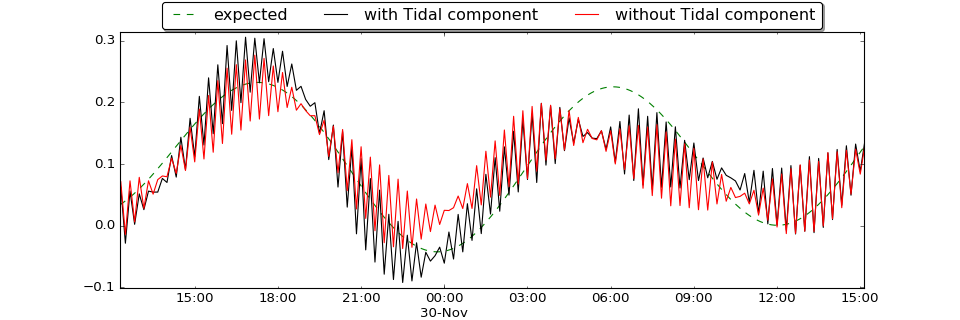

In [56]:
ax=med_d1.plot(figsize=(12,4),color='green', linestyle='--',linewidth=1, label='expected')
#med_d2.plot(ax=ax,color='orange',linestyle='--', label='pytides2' )
dat2['hd'].plot(ax=ax,color='k',linestyle='-', label='with Tidal component' )
dat2['fh'].plot(ax=ax,color='r',marker='',linestyle='-', label='without Tidal component' )
leg=ax.legend(loc='upper center', bbox_to_anchor=(.5,1.15), ncol=3, fancybox=True, shadow=True)